In [1]:
import os

import holoviews as hv
import numpy as np
import lancet

from topo.analysis.command import *
from featuremapper.analysis.raster import fft_power
from featuremapper.analysis.pinwheels import PinwheelAnalysis
from featuremapper.analysis.hypercolumns import PowerSpectrumAnalysis
from topo.analysis.command import *

import topo
from topo.analysis import Collector
from topo.submodel.gcal import ArraySpec

from topo.command import runscript  # In order to check the model files load correctly
from topo.misc.lancext import RunBatchCommand, topo_metadata

from analysis import *
from components.lespi import ModelSEPI

## Experimental Setup

In [2]:
batch_name = 'SEPI_Robustness'

# Model options
laterals = True

# Measurements
isosuppression = False
sizetuning = False
frequencytuning = False
complexity = False
isosuppression = False
flankers = False

# Define times
times = [1000*i for i in range(21)]
print("Collection times start at %s and end at %s" % (min(times), max(times)))

# Define Args
constants = lancet.Args(area=3.0, laterals=laterals)
parameter_space = lancet.Range('latexc_strength', 0, 3, 11) * lancet.Range('contrast', 10, 100, 10)
batch_arguments =  constants * parameter_space * lancet.Args(times=times)

Collection times start at 0 and end at 20000


## Load model

In [ ]:
topo.sim.model = ModelSEPI(laterals=laterals)
sepi = topo.sim.model.specification

### Define Collector

In [ ]:
c = Collector()

# Sheet activities
c.Activity.Retina =         c.collect(sepi.sheets.Retina)
c.Activity.V1Exc  =         c.collect(sepi.sheets.V1Exc)
c.Activity.V1PV   =         c.collect(sepi.sheets.V1PV)
# Connection fields
c.CFs.LGNOnAfferent =       c.collect(sepi.projections.V1Exc.LGNOnAfferent,  grid=True)
c.CFs.LGNOffAfferent =      c.collect(sepi.projections.V1Exc.LGNOffAfferent, grid=True)
c.CFs.PVLGNOnAfferent =       c.collect(sepi.projections.V1PV.LGNOnAfferent,  grid=True)
c.CFs.PVLGNOffAfferent =      c.collect(sepi.projections.V1PV.LGNOffAfferent, grid=True)
c.CFs.PV2Exc =   c.collect(sepi.projections.V1Exc.PVInhibition, grid=True)
c.CFs.Exc2PV =   c.collect(sepi.projections.V1PV.LateralPV, grid=True)
if laterals:
    c.CFS.LateralExcitatory = c.collect(sepi.projections.V1Exc.LateralExcitatory, grid=True)

# OR preference measurement
c.collect(measure_or_pref)
# Sheet activities
c.Activity.Retina =         c.collect(sepi.sheets.Retina)
c.Activity.V1Exc =             c.collect(sepi.sheets.V1Exc)

# Homeostatic threshold
c.HomeostaticThreshold.V1Exc = c.collect(ArraySpec('V1Exc.output_fns[0].t'),
                                         group='Homeostatic Threshold')

# OR preference measurement
c.collect(measure_or_pref, frequencies=[1.4, 1.6, 1.8])
c.collect(measure_response, durations=list(np.linspace(0,1,21)))

# Analysis
c.Pinwheels.V1Exc =            c.analyze(c.ref.OrientationPreference.V1Exc
                                         * c.ref.OrientationSelectivity.V1Exc, PinwheelAnalysis)
c.FFTAnalysis.V1Exc =          c.analyze(c.ref.OrientationPreference.V1Exc, PowerSpectrumAnalysis)

## Launcher

In [ ]:
# Local or on cluster
QSUB = True
# Open diff in pager or not
SHOW_DIFF = True

ty_file = './sepi.ty'
metadata = topo_metadata()
output_directory = os.path.join(os.getcwd(), 'data')

lancet.review_and_launch.output_directory = output_directory


qsub_options = dict(b='y',
                    pe=('sharedmem', '4'),   # Parallel environment allocation
                    v='OMP_NUM_THREADS=4')   # Must match slot allocation above.
                    #l='h_rt=05:59:00',       # Time resource allocation)

@lancet.review_and_launch()
def launch():
    runbatch_cmd = RunBatchCommand(ty_file, c, metadata=batch_arguments.varying_keys, snapshot=False)
    Launcher = lancet.QLauncher if QSUB else lancet.Launcher
    return Launcher(batch_name, batch_arguments, runbatch_cmd,  metadata=metadata(), 
                    **({'qsub_flag_options':qsub_options} if QSUB else {}))
launch()

# Results

In [2]:
from analysis.progress import ProgressWidget, load_table
hv.notebook_extension('bokeh', width=95)

In [3]:
path = './data/2016-05-10_1254-SEPI_Robustness'
ProgressWidget(path)

:Layout
   .DynamicMap.I   :DynamicMap   [Time]
   .DynamicMap.II  :DynamicMap   [Time]
   .DynamicMap.III :DynamicMap   [Time]
   .DynamicMap.IV  :DynamicMap   [Time]

In [4]:
table = load_table(path)
data = hv.core.io.Unpickler.collect(table, drop=['time', 'Index', 'tid', 'timestamps'])

## Robustness - Similarity, Selectivity, Map quality

In [5]:
hv.notebook_extension('matplotlib')
%output widgets='live' max_frames=10000

In [6]:
orpref = data.OrientationPreference.V1Exc() 
orsel  = data.OrientationSelectivity.V1Exc()

### Similarity

In [31]:
dims = ['latexc_strength', 'contrast']
maps = orpref.select(x=(-1, 1), y=(-1,1)).reindex(dims+['Time']).groupby(dims)
similarity = hv.HoloMap(kdims=dims)
for k, m in maps.items():
    if 20000 in m.keys():
        similarity[k] = hv.Table(similarity_analysis(m).reduce(['x', 'y'], np.mean), datatype=['dataframe']).to.curve(['Time'], ['z'])

:HeatMap   [latexc_strength,contrast]   (Stability)
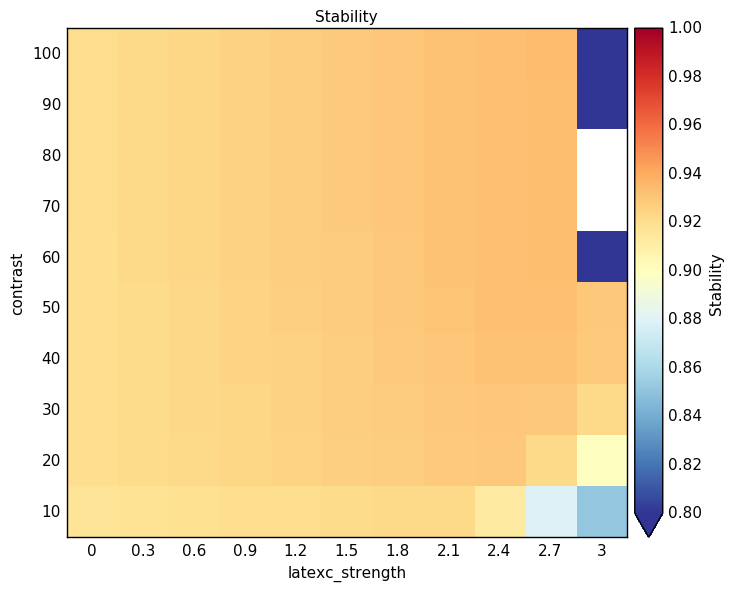

In [32]:
%%output size=200 dpi=100
%%opts HeatMap (clims=(0.8, 1)) [colorbar=True show_values=False]
similarity_hm = similarity.reduce(['Time'], np.mean).table(datatype='dataframe').to.heatmap(dims, ['z'], group='Stability')
similarity_hm.data = similarity_hm.data.rename(columns={'z': 'Stability'})
similarity_hm.vdims = [hv.Dimension('Stability')]
similarity_hm

### Selectivity

In [37]:
maps = orsel.select(x=(-1, 1), y=(-1,1)).reindex().groupby(dims)
selectivity = hv.HoloMap(kdims=dims)
for k, sel in maps.items():
    if 20000 in m.keys():
        selectivity[k] = sel.reduce(['x', 'y'], np.mean)

:HeatMap   [latexc_strength,contrast]   (Orientation Selectivity)
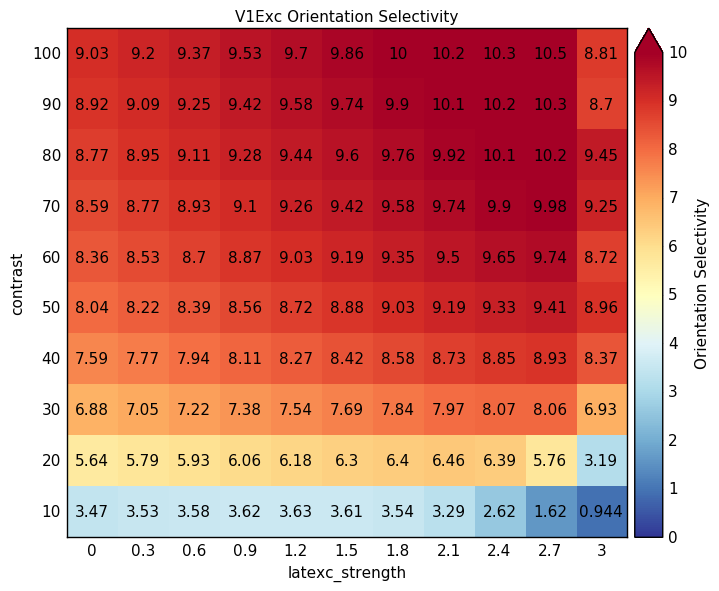

In [39]:
%%output size=200 dpi=100
%%opts HeatMap (clims=(0, 10)) [colorbar=True]
selectivity_hm = selectivity.reduce(['Time'], np.mean).to.heatmap(group='Orientation Selectivity')
selectivity_hm.vdims = [hv.Dimension('Orientation Selectivity', value_format=lambda x: '%.3g' % x)]
selectivity_hm.sort()

## Pinwheel Density

In [11]:
orpref_20k = orpref.select(Time=20000, x=(-1, 1), y=(-1,1))

In [12]:
pinwheel_results = hv.HoloMap(kdims=dims)
for k, group in orpref_20k.groupby(dims).items():
    try:
        pinwheel_results[k] = PowerSpectrumAnalysis(group, gamma_k=3.0)
    except Exception as e:
        print e
        pass
pinwheel_results = pinwheel_results.collate()
pwd_metrics = pinwheel_results.PowerSpectrum_Analysis.V1Exc.dframe()

Time: 000000.00 PinwheelAnalysis: Contour identification failed:
zero-size array to reduction operation minimum which has no identity
Time: 000000.00 PinwheelAnalysis: Contour identification failed:
zero-size array to reduction operation minimum which has no identity
Time: 000000.00 PinwheelAnalysis: Contour identification failed:
zero-size array to reduction operation minimum which has no identity


:Layout
   .Pinwheel_Density.I        :HeatMap   [latexc_strength,contrast]   (rho)
   .Pinwheel_Density_Metric.I :HeatMap   [latexc_strength,contrast]   (rho_metric)
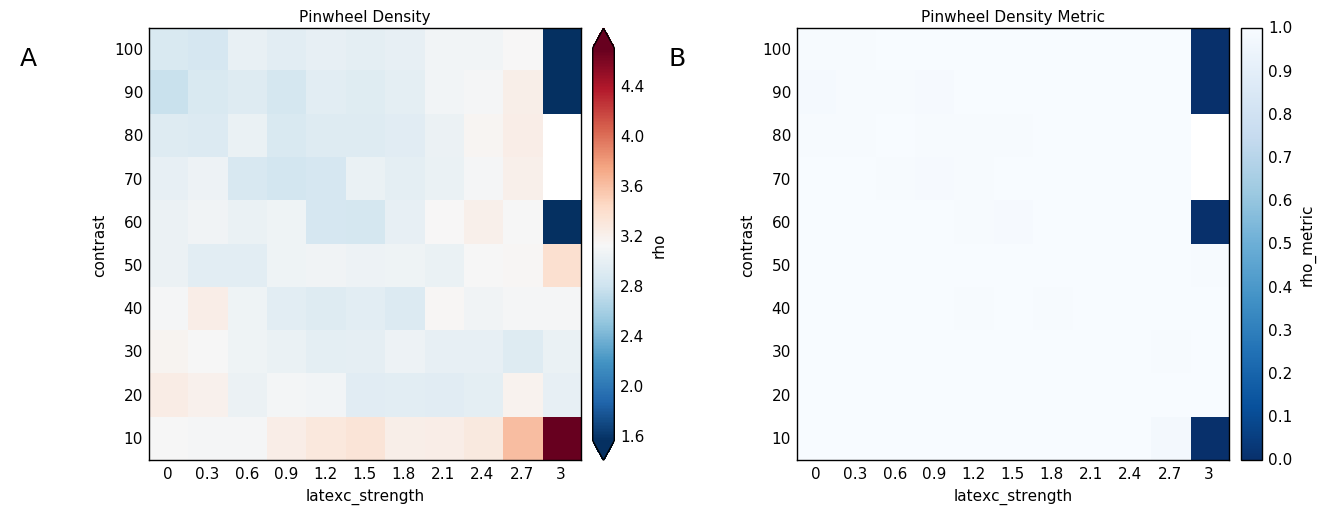

In [13]:
%%output size=150 dpi=100
%%opts HeatMap.Pinwheel_Density (clims=(np.pi/2., np.pi*1.5) cmap='RdBu_r') [show_values=False colorbar=True]
%%opts HeatMap.Pinwheel_Density_Metric (clims=(0, 1) cmap='Blues_r') [show_values=False colorbar=True]
pwdm = hv.Table(pwd_metrics).to.heatmap(dims, ['rho_metric'], [], group='Pinwheel Density Metric')
pwd = hv.Table(pwd_metrics).to.heatmap(dims, ['rho'], [], group='Pinwheel Density')
pwd + pwdm

### Local homgeneity Index

In [14]:
import analysis

In [15]:
lhi_20k = analysis.LocalHomogeneityIndex(orpref_20k)
lhi_table = lhi_20k.reduce(function=np.mean)

:HoloMap   [Time,Duration]
   :HeatMap   [latexc_strength,contrast]   (LHI)
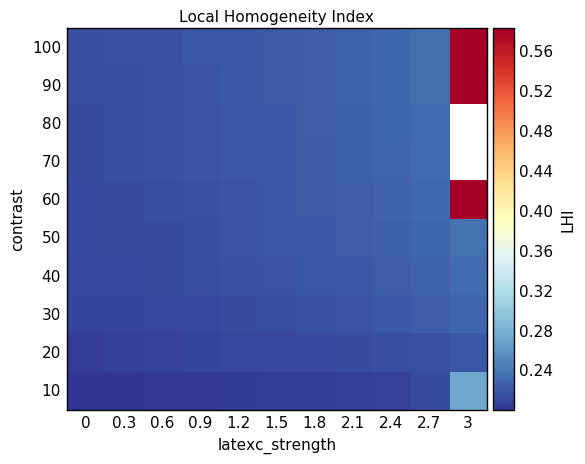

In [16]:
%%output size=150 dpi=100
%%opts HeatMap [show_values=False colorbar=True]
lhi = lhi_table.to.heatmap(dims).relabel(label='')
lhi

### Center of Gravity shift

In [17]:
lgn_on = data.CFs.LGNOnAfferent.select(time=20000)()
grouped_cfs = hv.Collator(lgn_on, merge_type=hv.HoloMap, kdims=lgn_on.kdims)().reindex().groupby(dims).select(X=(-1, 1), Y=(-1,1))

In [41]:
distance_map = {}
for (tc, exp), group in grouped_cfs.items():
    if len(group):
        total_distance = 0
    else:
        total_distance = np.NaN
    for (x, y), cf in group.items():
        cf_df = cf.dframe()
        normed_weights = cf_df.z/np.sum(cf_df.z)
        cogx = np.sum(cf_df.x * normed_weights)
        cogy = np.sum(cf_df.y * normed_weights)
        total_distance += np.sqrt(((cogx - x)**2) + ((cogy - y)**2))
    distance_map[tc, exp] = total_distance/len(group)

:HeatMap   [latexc_strength,contrast]   (CoG Shift)
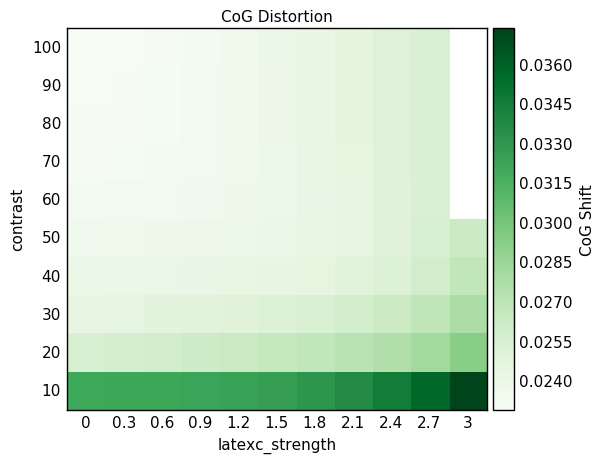

In [42]:
%%output size=150 dpi=100
%%opts HeatMap [show_values=False colorbar=True] (cmap='Greens')
cog = hv.HeatMap(distance_map, group='CoG Distortion', kdims=dims, vdims=['CoG Shift']).sort()
cog

### Overview

In [33]:
%%output size=150 dpi=100 fig='svg' filename='SEPI_Robustness'
%%opts Layout [hspace=0.5 vspace=0.]
%%opts HeatMap [sublabel_position=(-0.25, 0.9) clipping_colors=dict(NaN='k') colorbar=True sublabel_size=24 fontsize={'title':20,'xlabel':16,'ylabel':16,'ticks':14} show_values=False] {+framewise}
%%opts HeatMap.Stability (cmap='Blues' clims=(0.8, 1)) [cbar_ticks=[0.8, 0.85, 0.9, 0.95, 1]]
%%opts HeatMap.Orientation_Selectivity (cmap='Reds', clims=(0, 10)) 
%%opts HeatMap.Local_Homogeneity_Index (cmap='Purples' clims=(0, 0.5))
%%opts HeatMap.Pinwheel_Density [cbar_ticks=[(np.pi/2., r'$\pi/2$'), (np.pi, r'$\pi$'), (np.pi, r'$\pi$'), (np.pi*1.5, r'$3(\pi/2)$')]] (cmap='RdBu_r')
%%opts HeatMap.CoG_Distortion (clims=(0, 0.4))
linearity = similarity_hm + selectivity_hm.clone(label='') + lhi + pwd + cog
linearity.select(pv_timeconstant=(0.1,1.01)).cols(3) 

:Layout
   .Stability.I               :HeatMap   [latexc_strength,contrast]   (Stability)
   .Orientation_Selectivity.I :HeatMap   [latexc_strength,contrast]   (Orientation Selectivity)
   .Local_Homogeneity_Index.I :HoloMap   [Time,Duration]
      :HeatMap   [latexc_strength,contrast]   (LHI)
   .Pinwheel_Density.I        :HeatMap   [latexc_strength,contrast]   (rho)
   .CoG_Distortion.I          :HeatMap   [latexc_strength,contrast]   (CoG Shift)

#### Figure 5.11: 

Parameter explorations of three separate metrics of orientation map development using the SEPI model. In comparison to the SCAL model, the model is far more robust to strong lateral excitation and maintains almost uniform stability across almost all explored parameter values. Uncoupling of excitation and inhibition allows the model to handle changes in parameter strengths in a robust and responsive way.

In [35]:
metrics = None
for metric in linearity + pwdm:
    if metrics is None:
        metrics = metric.dframe()
    else:
        metrics = metrics.merge(metric.dframe(), on=dims)

In [40]:
%%output size=200 fig='svg' filename='SEPI_Robustness_Correlations'
%%opts Overlay [xrotation=90 invert_yaxis=True show_frame=False] VLine (color='w' lw=7) HLine (color='w' lw=7)
%%opts HeatMap [colorbar=True show_values=False ] (clims=(-1, 1) cmap='RdBu_r')
corr = metrics.corr()
corr = corr.reindex_axis([c for c in sorted(corr.columns) if c != 'rho'], axis=1)
hv.HeatMap([((c, c2), corr[c][c2] if c != c2 else np.NaN) for i, c in enumerate(corr)
            for c2 in corr.columns[i+1:]], kdims=[' ', '  '],  vdims=['Pearson Correlation']) *\
hv.Overlay([hv.VLine(i) for i in range(7)]) * hv.Overlay([hv.HLine(i) for i in range(7)])

:Overlay
   .HeatMap.I :HeatMap   [ ,  ]   (Pearson Correlation)
   .VLine.I   :VLine   [x,y]
   .VLine.II  :VLine   [x,y]
   .VLine.III :VLine   [x,y]
   .VLine.IV  :VLine   [x,y]
   .VLine.V   :VLine   [x,y]
   .VLine.VI  :VLine   [x,y]
   .VLine.VII :VLine   [x,y]
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]
   .HLine.IV  :HLine   [x,y]
   .HLine.V   :HLine   [x,y]
   .HLine.VI  :HLine   [x,y]
   .HLine.VII :HLine   [x,y]